## 初识数据可视化


首先将caffe的根目录作为当前目录，然后加载caffe程序自带的小猫图片，并显示。

图片大小为360x480，三通道

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import caffe
caffe_root = '/home/yeler082/caffe'
import os,sys

In [2]:
import matplotlib
print matplotlib.__version__

2.2.3


(360, 480, 3)


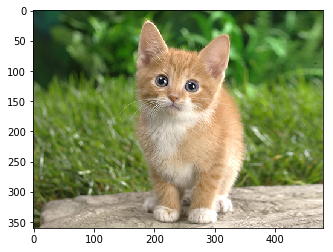

In [3]:
os.chdir(caffe_root)
sys.path.insert(0,caffe_root+'python')
im = caffe.io.load_image('examples/images/cat.jpg')
print im.shape
plt.imshow(im)


打开examples/net_surgery/conv.prototxt文件，修改两个地方

一是将input_shape由原来的是（1，1，100，100）修改为(1,3,100,100),即由单通道灰度图变为三通道彩色图。

二是将过滤器个数(num_output)由3修改为16，多增加一些filter, 当然保持原来的数不变也行。

其它地方不变，修改后的prototxt如下：只有一个卷积层


In [4]:
! cat examples/net_surgery/conv.prototxt

# Simple single-layer network to showcase editing model parameters.
name: "convolution"
layer {
  name: "data"
  type: "Input"
  top: "data"
  input_param { shape: { dim: 1 dim: 3 dim: 100 dim: 100 } }
}
layer {
  name: "conv"
  type: "Convolution"
  bottom: "data"
  top: "conv"
  convolution_param {
    num_output: 16
    kernel_size: 5
    stride: 1
    weight_filler {
      type: "gaussian"
      std: 0.01
    }
    bias_filler {
      type: "constant"
      value: 0
    }
  }
}


Here is the revised file

In [5]:
! cat examples/net_surgery/conv.prototxt

# Simple single-layer network to showcase editing model parameters.
name: "convolution"
layer {
  name: "data"
  type: "Input"
  top: "data"
  input_param { shape: { dim: 1 dim: 3 dim: 100 dim: 100 } }
}
layer {
  name: "conv"
  type: "Convolution"
  bottom: "data"
  top: "conv"
  convolution_param {
    num_output: 16
    kernel_size: 5
    stride: 1
    weight_filler {
      type: "gaussian"
      std: 0.01
    }
    bias_filler {
      type: "constant"
      value: 0
    }
  }
}



将图片数据加载到blobs，但反过来，我们也可以反过来从blob中提取出原始数据，并进行显示。

显示的时候要注意各维的顺序，如blobs的顺序是(1,3,360,480),从前往后分别表示1张图片，3三个通道，

图片大小为360x480，需要调用transpose改变为(360,480,3)才能正常显示。

其中用data[0]表示第一张图片，下标从0开始，此例只有一张图片，因此只能是data[0].

分别用data[0,0],data[0,1]和data[0,2]表示该图片的三个通道。


data-blobs (1, 3, 360, 480)


(-0.5, 479.5, 359.5, -0.5)

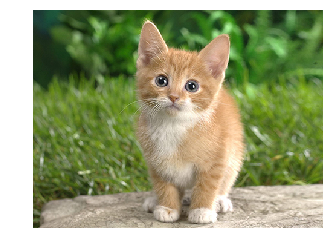

In [6]:
net = caffe.Net('examples/net_surgery/conv.prototxt',caffe.TEST)
im_input = im[np.newaxis,:,:,:].transpose(0,3,1,2)
print "data-blobs",im_input.shape
net.blobs['data'].reshape(*im_input.shape)
net.blobs['data'].data[...] = im_input
plt.imshow(net.blobs['data'].data[0].transpose(1,2,0))
plt.axis('off')

In [7]:
plt.rcParams['image.cmap'] = 'gray'

def show_data(data,head,padsize=1, padval=0):
    data -= data.min()
    data /= data.max()
    
    # force the number of filters to be square
    n = int(np.ceil(np.sqrt(data.shape[0])))
    padding = ((0, n ** 2 - data.shape[0]), (0, padsize), (0, padsize)) + ((0, 0),) * (data.ndim - 3)
    data = np.pad(data, padding, mode='constant', constant_values=(padval, padval))
    
    # tile the filters into an image
    data = data.reshape((n, n) + data.shape[1:]).transpose((0, 2, 1, 3) + tuple(range(4, data.ndim + 1)))
    data = data.reshape((n * data.shape[1], n * data.shape[3]) + data.shape[4:])
    plt.figure()
    plt.title(head)
    plt.imshow(data)
    plt.axis('off')

从blobs数据中将原始图片提取出来，并分别显示不同的通道图

data-blobs: (1, 3, 360, 480)


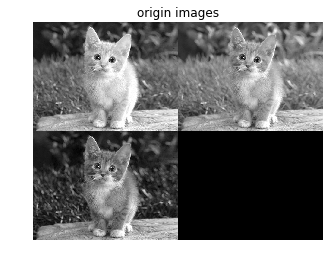

In [8]:
print "data-blobs:",net.blobs['data'].data.shape
show_data(net.blobs['data'].data[0],'origin images')


调用forward()执行卷积操作，blobs数据发生改变。由原来的(1,3,360,480)变为（1，16，356，476）。

并初始化生成了相应的权值，权值数据为(16,3,5,5)。

最后调用两次show_data来分别显示权值和卷积过滤后的16通道图片。


data-blobs: (1, 3, 360, 480)
conv-blobs: (1, 16, 356, 476)
weight-blobs: (16, 3, 5, 5)


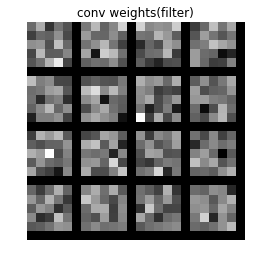

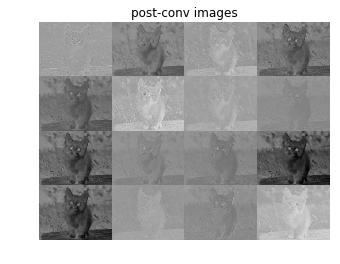

In [9]:
net.forward()
print "data-blobs:",net.blobs['data'].data.shape
print "conv-blobs:",net.blobs['conv'].data.shape
print "weight-blobs:",net.params['conv'][0].data.shape
show_data(net.params['conv'][0].data[:,0],'conv weights(filter)')
show_data(net.blobs['conv'].data[0],'post-conv images')